In [14]:
# Import necessary libraries
import os
import random
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from torch import optim
from torch.nn import functional as F
from collections import Counter
from sklearn.metrics import classification_report

# Set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


## Data Preprocessing and Loading

In this section, we define the transformations applied to the training and test datasets, and we load the CIFAR-10 dataset. We also split the training dataset into training and validation sets, and finally, create DataLoader objects for each dataset.



In [2]:
# Define transformations for training and test datasets
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Width & Height shift (10%)
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

# Define normalization for test set (without augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
full_train_dataset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)
test_dataset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)

# Split training dataset into training (45,000 samples) and validation (5,000 samples)
train_size = 45000
val_size = 5000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Training set size: 45000
Validation set size: 5000
Test set size: 10000


 ## Exploratory Data Analysis (EDA)

In this section, we visualize some samples from the training dataset. We display 10 images in a grid format, with their corresponding labels. The images are transformed back to their original format for better visualization.

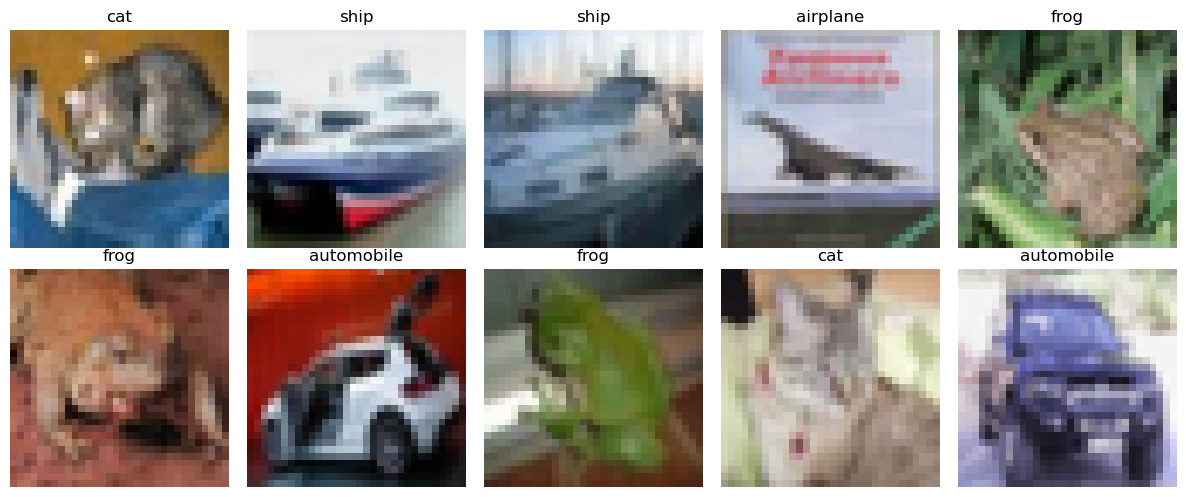

In [3]:
# CIFAR-10 class labels
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Function to denormalize and convert tensor to numpy array
def denormalize(img_tensor):
    img_tensor = img_tensor * 0.5 + 0.5  # Undo normalization (mean = 0.5, std = 0.5)
    return img_tensor.numpy().transpose(1, 2, 0)  # Convert to HWC format for visualization

# Get a batch of images
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Plot images with their labels
fig, axes = plt.subplots(2, 5, figsize=(12, 5))  # 2 rows, 5 columns
axes = axes.flatten()

for i in range(10):
    img = denormalize(images[i])  # Convert back to original format
    label = class_names[labels[i].item()]  # Get class name

    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis("off")  # Remove axis for a cleaner look

plt.tight_layout()
plt.show()



## Class Distribution
We also check the distribution of classes in the training dataset. The distribution is expected to be uniform, with each class having approximately 5,000 samples.

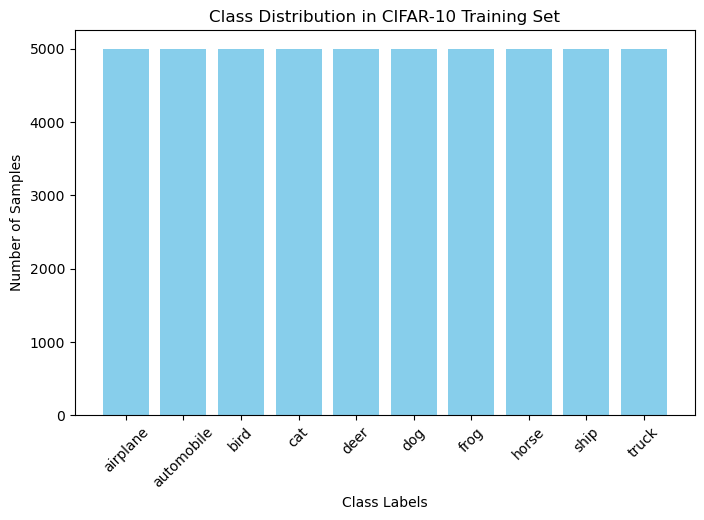

In [4]:
# Get all labels from training dataset
all_labels = [label for _, label in full_train_dataset]

# Count occurrences of each class
class_counts = Counter(all_labels)

# Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_names, [class_counts[i] for i in range(10)], color='skyblue')
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in CIFAR-10 Training Set")
plt.xticks(rotation=45)
plt.show()



## Define CNN Model Architecture

In [5]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        
        self.features = nn.Sequential(
            # First Conv Block: 32 filters
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            
            # Second Conv Block: 64 filters
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            
            # Third Conv Block: 128 filters
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 56),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(56, num_classes)
        )
    # Define the forward pass
    # This method defines how the input data flows through the network
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
    

# Initialize the model
model = CNNModel(num_classes=10).to(device)
# Print model summary
print(model)

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [6]:
# Print model summary and count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 402770


# Early Stopping
In this section, we define the EarlyStopping class, which monitors the validation loss during training. If the validation loss does not improve for a specified number of epochs (patience), the training stops early to prevent overfitting.

In [8]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=5, min_delta=0, path="best_model.pth"):
        """
        Args:
            patience (int): How many epochs to wait after the last improvement before stopping.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.best_val_loss = np.Inf
        self.counter = 0

    def __call__(self, val_loss, model):
        if val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            print(f"✅ Model improved and saved with Validation Loss: {val_loss:.4f}")
        else:
            self.counter += 1
            print(f"⏳ EarlyStopping Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                print("⛔ Early stopping triggered!")
                return True  # Signal to stop training
        return False  # Continue training


In [ ]:
# Define the optimizer and loss function
# Use Adam optimizer with weight decay
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# Use CrossEntropyLoss with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001, path="best_model.pth")


# Training the model
In this section, we define the training process for the CNN model. We use the Adam optimizer and CrossEntropyLoss as the loss function. The model is trained for 50 epochs, and we print the training loss and accuracy after each epoch.

✅ Model improved and saved with Validation Loss: 1.5867
Epoch 1/50 | Train Loss: 1.8469, Train Acc: 0.3527 | Val Loss: 1.5867, Val Acc: 0.5036 | LR: [0.001]
✅ Model improved and saved with Validation Loss: 1.4370
Epoch 2/50 | Train Loss: 1.6053, Train Acc: 0.4918 | Val Loss: 1.4370, Val Acc: 0.5798 | LR: [0.001]
✅ Model improved and saved with Validation Loss: 1.3484
Epoch 3/50 | Train Loss: 1.5012, Train Acc: 0.5505 | Val Loss: 1.3484, Val Acc: 0.6122 | LR: [0.001]
✅ Model improved and saved with Validation Loss: 1.2555
Epoch 4/50 | Train Loss: 1.4344, Train Acc: 0.5847 | Val Loss: 1.2555, Val Acc: 0.6584 | LR: [0.001]
✅ Model improved and saved with Validation Loss: 1.2012
Epoch 5/50 | Train Loss: 1.3854, Train Acc: 0.6113 | Val Loss: 1.2012, Val Acc: 0.6918 | LR: [0.001]
✅ Model improved and saved with Validation Loss: 1.1680
Epoch 6/50 | Train Loss: 1.3479, Train Acc: 0.6309 | Val Loss: 1.1680, Val Acc: 0.7100 | LR: [0.001]
✅ Model improved and saved with Validation Loss: 1.1363
Ep

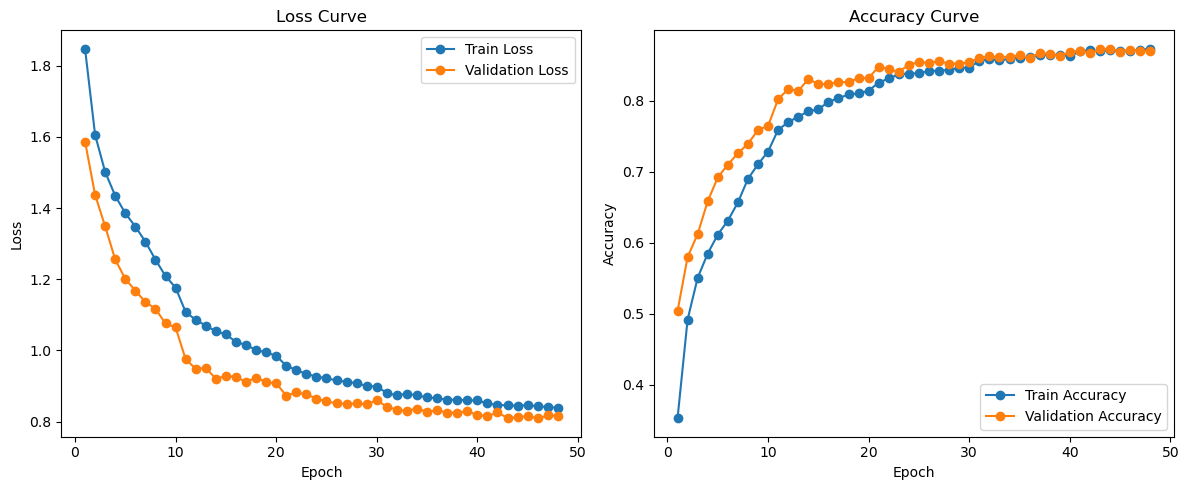

In [10]:
# Set number of epochs and initialize metric storage lists
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with Early Stopping
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()           # Reset gradients
        outputs = model(images)         # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                 # Backward pass
        optimizer.step()                # Update model parameters

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)  # Get predicted labels
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / total_train
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    running_loss_val = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_loss_val / total_val
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Check Early Stopping condition
    if early_stopping(val_loss, model):
        break

    # Step the scheduler
    scheduler.step()

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f} | "
        f"LR: {scheduler.get_last_lr()}"
    )

# Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
In this section, we evaluate the trained model on the validation and test datasets. We calculate the accuracy and loss for both datasets. The model's performance is printed, showing the accuracy on the validation and test sets.

In [11]:
# Evaluate the model on the test set
def evaluate_model(model, dataloader, device):
    """
    Evaluates the model on a given dataloader.
    
    Parameters:
        model (nn.Module): Trained model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run evaluation on.
    
    Returns:
        accuracy (float): The accuracy over the dataset.
        all_labels (list): List of true labels.
        all_preds (list): List of predicted labels.
    """
    model.eval()  # Set model to evaluation mode
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    accuracy = total_correct / total_samples
    return accuracy, all_labels, all_preds


In [12]:
# Evaluate on Training Set
train_accuracy, train_labels, train_preds = evaluate_model(model, train_loader, device)
# Evaluate on Validation Set
val_accuracy, val_labels, val_preds = evaluate_model(model, val_loader, device)
# Evaluate on Test Set
test_accuracy, test_labels, test_preds = evaluate_model(model, test_loader, device)

print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Training Accuracy: 91.15%
Validation Accuracy: 87.08%
Test Accuracy: 87.18%


In [15]:
# Classification Report
print("Classification Report on Test Set:")
print(classification_report(test_labels, test_preds, target_names=class_names))

Classification Report on Test Set:
              precision    recall  f1-score   support

    airplane       0.91      0.86      0.88      1000
  automobile       0.95      0.93      0.94      1000
        bird       0.86      0.79      0.82      1000
         cat       0.83      0.68      0.75      1000
        deer       0.85      0.88      0.86      1000
         dog       0.77      0.85      0.81      1000
        frog       0.81      0.96      0.88      1000
       horse       0.92      0.89      0.90      1000
        ship       0.94      0.93      0.94      1000
       truck       0.89      0.95      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



# confusion matrix
In this section, we plot the confusion matrix for the test dataset. The confusion matrix provides a visual representation of the model's performance, showing how many samples from each class were correctly classified and how many were misclassified.

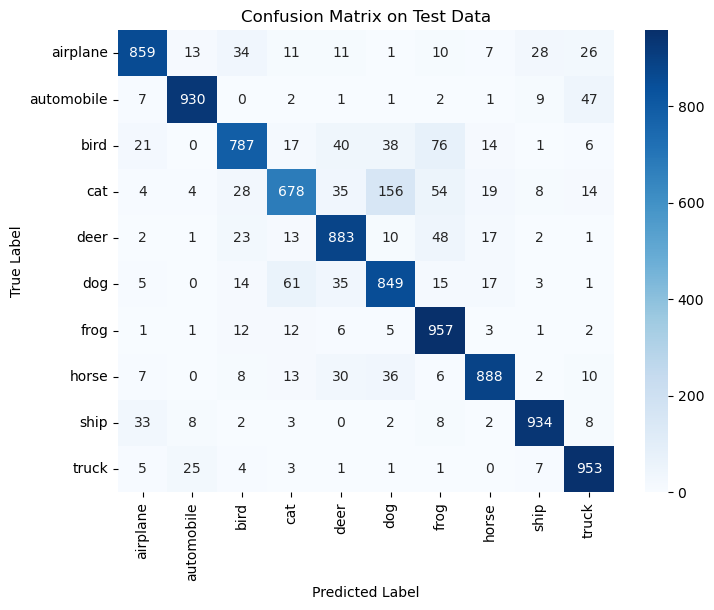

In [ ]:

# Assuming you have a list of class names for CIFAR-10
class_names = ["airplane", "automobile", "bird", "cat", "deer", 
               "dog", "frog", "horse", "ship", "truck"]

# Compute confusion matrix for test predictions
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Data')
plt.show()
